In [1]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import os
import math
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation ,Dropout , Flatten , Conv1D ,MaxPooling1D
from sklearn.preprocessing import MinMaxScaler
from keras.layers.recurrent import LSTM
from keras import losses
import tensorflow as tf
from keras import optimizers
import multiprocessing as mp
import time
%matplotlib inline

Using TensorFlow backend.
d:\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
d:\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
d:\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
d:\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] 
plt.rcParams['axes.unicode_minus']=False

In [3]:
dataset = pd.read_csv(r'.\Data\Stocks\hpq.us.txt')
df = dataset.sort_values('Date')
dataset.info()
dataset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12075 entries, 0 to 12074
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     12075 non-null  object 
 1   Open     12075 non-null  float64
 2   High     12075 non-null  float64
 3   Low      12075 non-null  float64
 4   Close    12075 non-null  float64
 5   Volume   12075 non-null  int64  
 6   OpenInt  12075 non-null  int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 660.5+ KB


,Date,Open,High,Low,Close,Volume,OpenInt
0,1970-01-02,0.30627,0.30627,0.30627,0.30627,2441124,0
1,1970-01-05,0.30627,0.31768,0.30627,0.31385,6219848,0
2,1970-01-06,0.31385,0.31385,0.30996,0.30996,4447522,0
3,1970-01-07,0.31385,0.31385,0.31385,0.31385,1872638,0
4,1970-01-08,0.31385,0.31768,0.31385,0.31385,4280330,0


In [4]:
dataset.tail()

,Date,Open,High,Low,Close,Volume,OpenInt
12070,2017-11-06,21.47,21.53,21.38,21.44,13309476,0
12071,2017-11-07,21.47,21.47,21.32,21.38,6245536,0
12072,2017-11-08,21.34,21.47,21.24,21.42,6061868,0
12073,2017-11-09,21.27,21.40,21.15,21.34,5844935,0
12074,2017-11-10,21.25,21.31,21.14,21.23,6276650,0


In [5]:
print(dataset)

             Date      Open      High       Low     Close    Volume  OpenInt
0      1970-01-02   0.30627   0.30627   0.30627   0.30627   2441124        0
1      1970-01-05   0.30627   0.31768   0.30627   0.31385   6219848        0
2      1970-01-06   0.31385   0.31385   0.30996   0.30996   4447522        0
3      1970-01-07   0.31385   0.31385   0.31385   0.31385   1872638        0
4      1970-01-08   0.31385   0.31768   0.31385   0.31385   4280330        0
...           ...       ...       ...       ...       ...       ...      ...
12070  2017-11-06  21.47000  21.53000  21.38000  21.44000  13309476        0
12071  2017-11-07  21.47000  21.47000  21.32000  21.38000   6245536        0
12072  2017-11-08  21.34000  21.47000  21.24000  21.42000   6061868        0
12073  2017-11-09  21.27000  21.40000  21.15000  21.34000   5844935        0
12074  2017-11-10  21.25000  21.31000  21.14000  21.23000   6276650        0

[12075 rows x 7 columns]


In [6]:
# 计算中间价格
high_prices = df.loc[:,'High'].to_numpy()
low_prices = df.loc[:,'Low'].to_numpy()
mid_prices = (high_prices+low_prices)/2.0
train_data = mid_prices[:11000]
test_data = mid_prices[11000:]
# 将最高价与最低价求均值，得到当天的均价
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)
smoothing_window_size = 2500
for di in range(0,10000,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])
train_data = train_data.reshape(-1)
test_data = scaler.transform(test_data).reshape(-1)
EMA = 0.0
gamma = 0.1
for ti in range(400):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

all_mid_data = np.concatenate([train_data,test_data],axis=0)

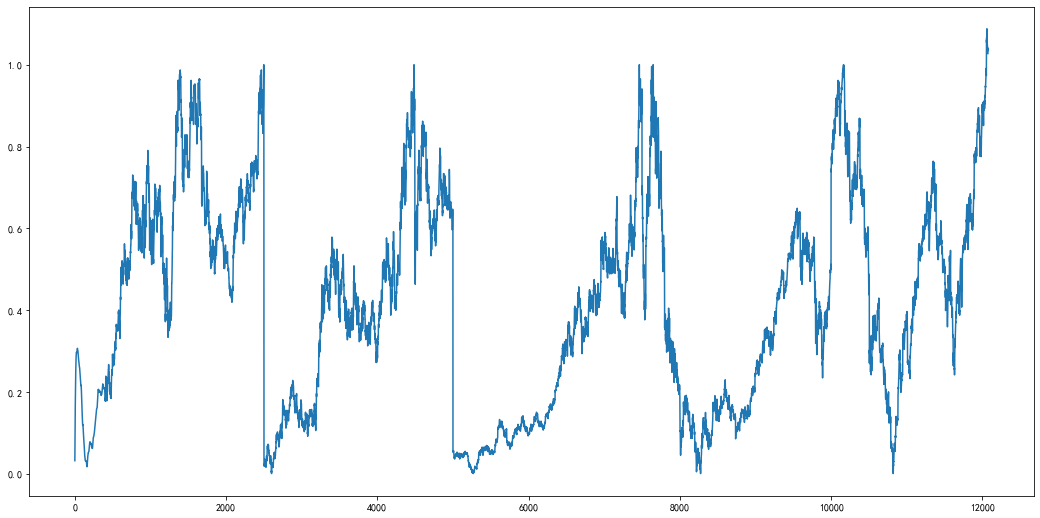

In [7]:
# 归一化后出现4个断点
plt.figure(figsize = (18,9))
plt.plot(all_mid_data)

In [8]:
def hurst(ts):
    ts = list(ts)
    N = len(ts)
    if N < 20:
        raise ValueError("Time series is too short! input series ought to have at least 20 samples!")

    max_k = int(np.floor(N/2))
    R_S_dict = []
    for k in range(10,max_k+1):
        R,S = 0,0
        # split ts into subsets
        subset_list = [ts[i:i+k] for i in range(0,N,k)]
        if np.mod(N,k)>0:
            subset_list.pop()
            #tail = subset_list.pop()
            #subset_list[-1].extend(tail)
        # calc mean of every subset
        mean_list=[np.mean(x) for x in subset_list]
        for i in range(len(subset_list)):
            cumsum_list = pd.Series(subset_list[i]-mean_list[i]).cumsum()
            R += max(cumsum_list)-min(cumsum_list)
            S += np.std(subset_list[i])
        R_S_dict.append({"R":R/len(subset_list),"S":S/len(subset_list),"n":k})
    
    log_R_S = []
    log_n = []
   # print(R_S_dict)
    for i in range(len(R_S_dict)):
        R_S = (R_S_dict[i]["R"]+np.spacing(1)) / (R_S_dict[i]["S"]+np.spacing(1))
        log_R_S.append(np.log(R_S))
        log_n.append(np.log(R_S_dict[i]["n"]))

    Hurst_exponent = np.polyfit(log_n,log_R_S,1)[0]
    return Hurst_exponent

In [9]:
def make_hurst_list(data,length=20):
    Hurst_list=[x for x in range(length-1)]
    for i in range(len(data)-length+1):
        ts=data[i:i+length]
        Hurst_list.append(hurst(ts))
    for i in range(length-1):
        Hurst_list[i]=Hurst_list[length-1]
    return Hurst_list


In [10]:
def run(i,length):
    print('线程',i,'启动')
    time_start=time.time()
#    Hurst_exponent= hurst(data[i:i+length])
    time_end=time.time()
    print('线程',i,'计算完毕，共耗时',time_end-time_start,'s')
    return 0
# 多进程版，上面那个太慢了！！！
# 这块别用 jupyter跑，不支持多线程
def make_hurst_list_pool(data,length=20):
    pool = mp.Pool()
    print("1")
    Hurst_list = [pool.apply_async(run, args=(i,length)) for i in range(100-length+1)]
    for i in range(length-1):
        Hurst_list[i]=Hurst_list[length-1]
    pool.close()
    pool.join()
    return Hurst_list

In [11]:
#Hurst_list = make_hurst_list_pool(all_mid_data,20)
#Hurst_list = make_hurst_list(all_mid_data,20)

jupyter notebook **不支持** 多线程，计算hurst的代码在calculate_hurst.py中

当然，使用上面的代码也行，单线程的，跑到天荒地老

In [12]:
hurst_df=pd.read_csv(r'.\hurst.csv')
hurst_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12075 entries, 0 to 12074
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   100     12075 non-null  float64
 1   150     12075 non-null  float64
 2   200     12075 non-null  float64
 3   500     12075 non-null  float64
 4   1000    12075 non-null  float64
 5   3000    12075 non-null  float64
dtypes: float64(6)
memory usage: 566.1 KB


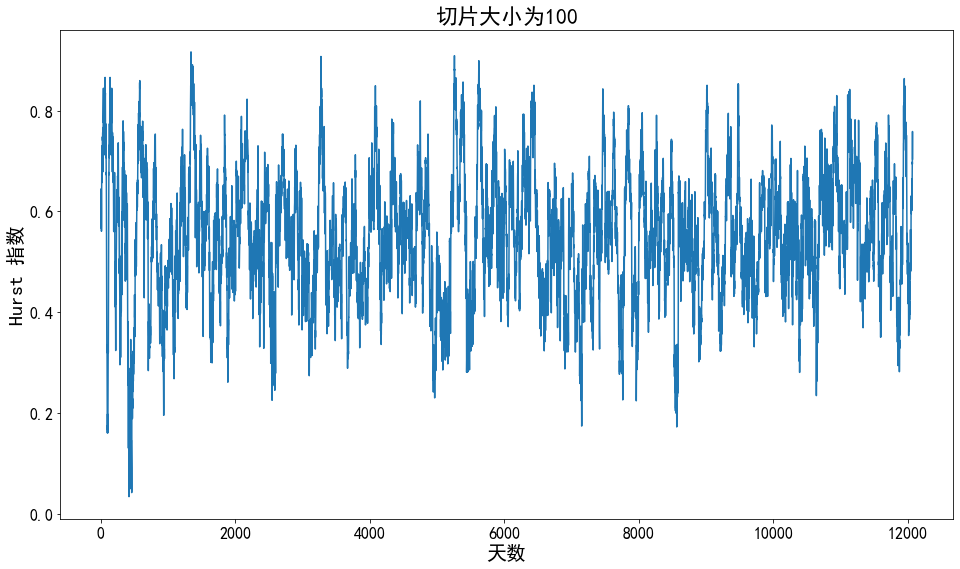

d:\tensorflow-gpu\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Figure size 1152x648 with 0 Axes>

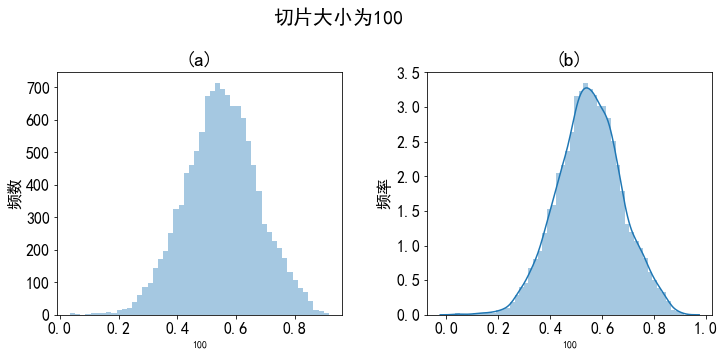

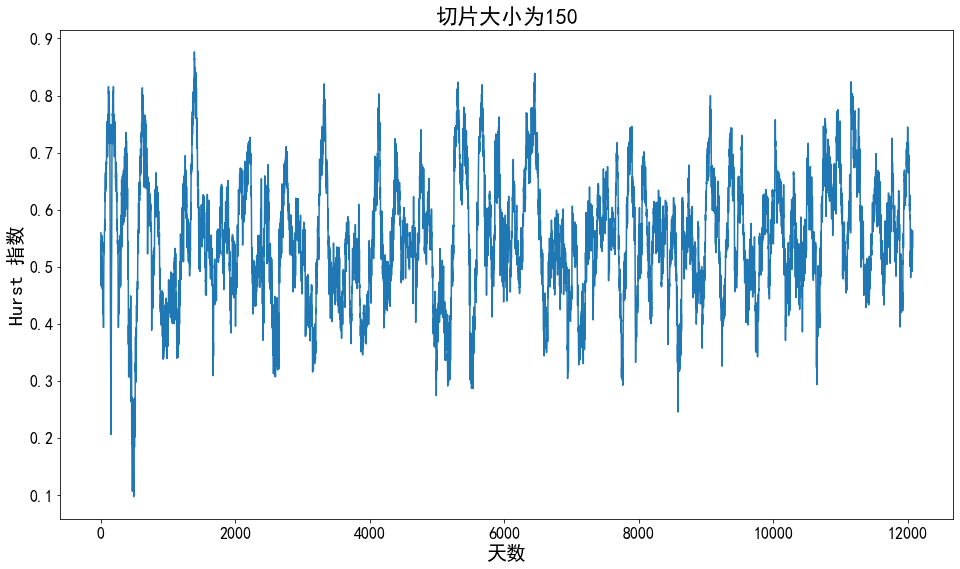

d:\tensorflow-gpu\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Figure size 1152x648 with 0 Axes>

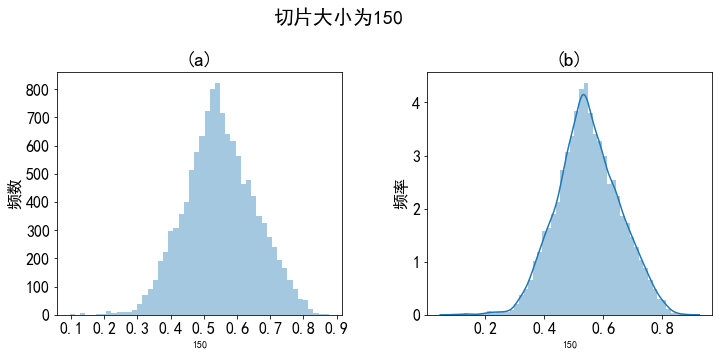

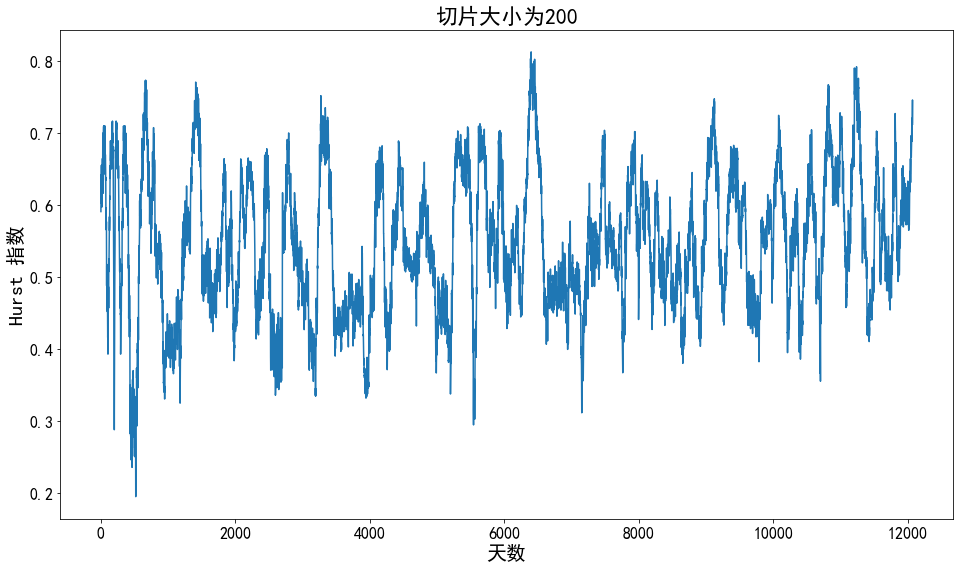

d:\tensorflow-gpu\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Figure size 1152x648 with 0 Axes>

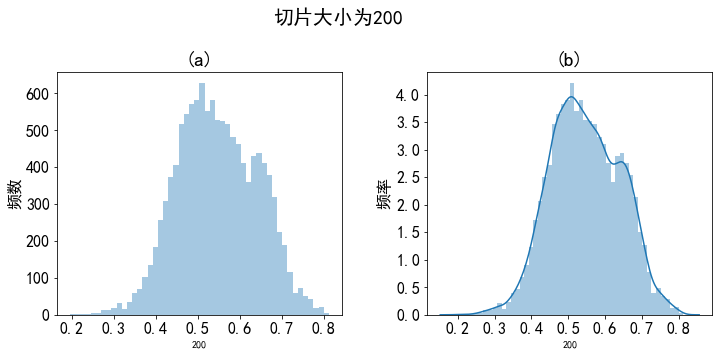

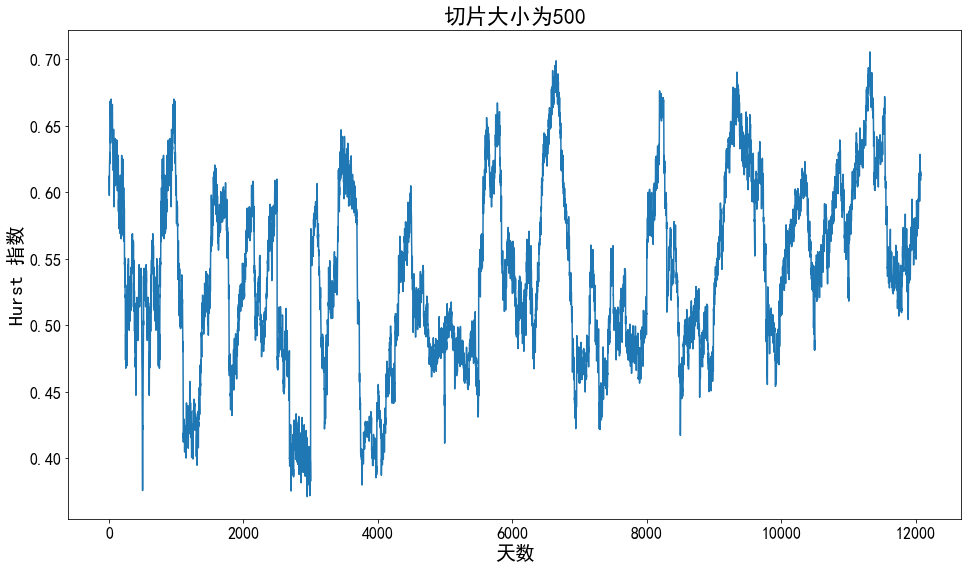

d:\tensorflow-gpu\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Figure size 1152x648 with 0 Axes>

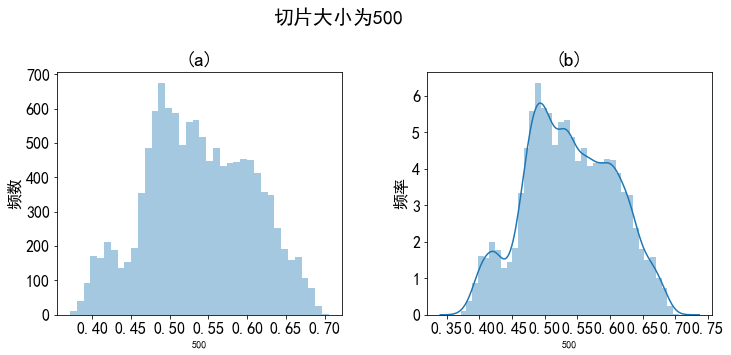

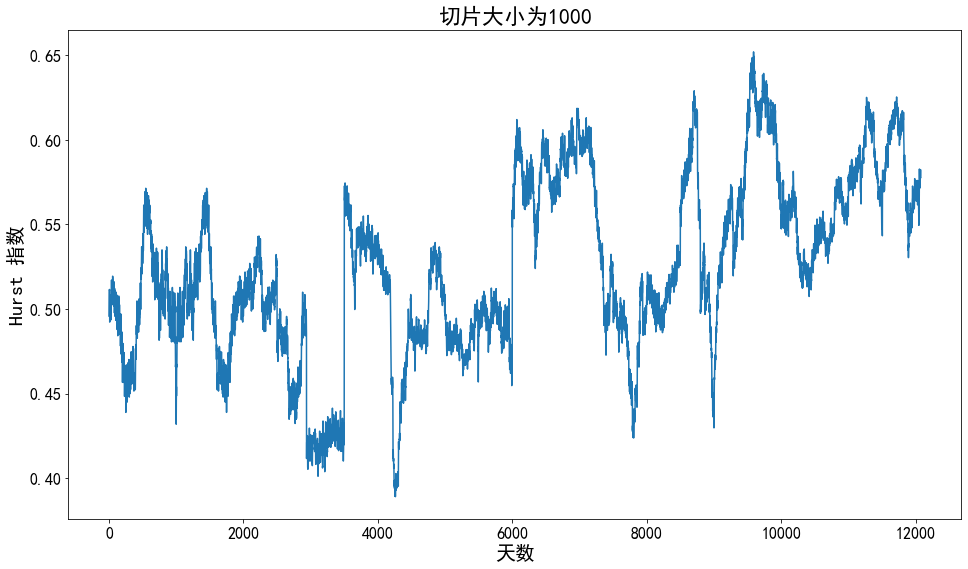

d:\tensorflow-gpu\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Figure size 1152x648 with 0 Axes>

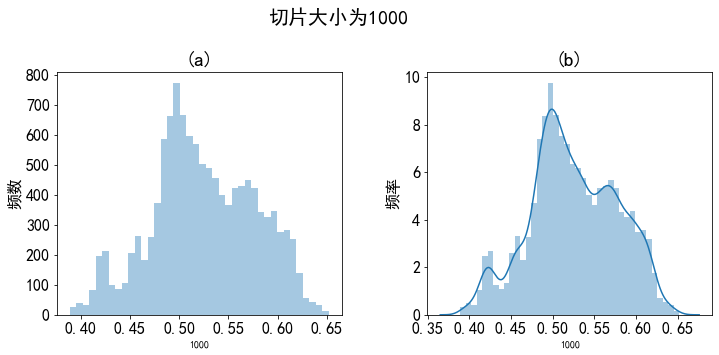

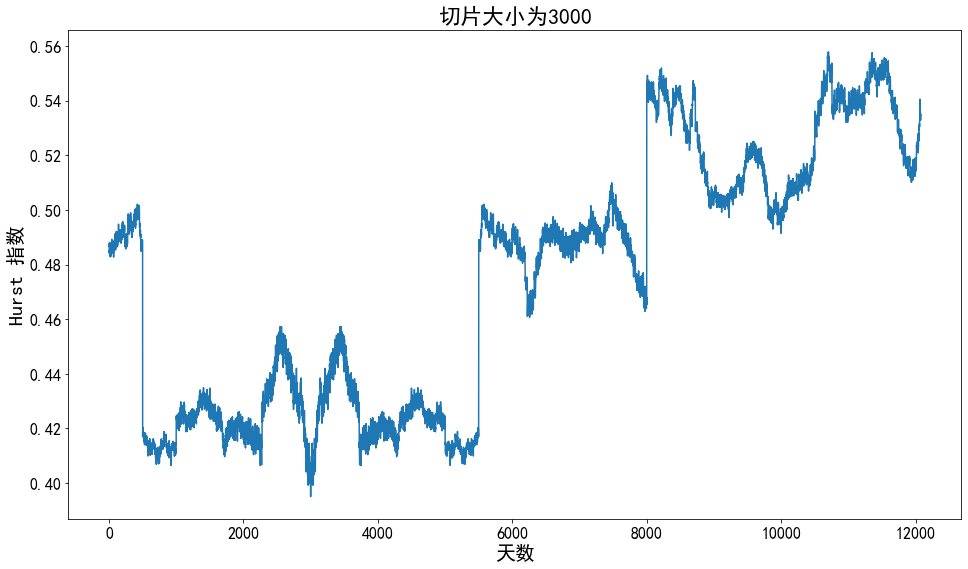

d:\tensorflow-gpu\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Figure size 1152x648 with 0 Axes>

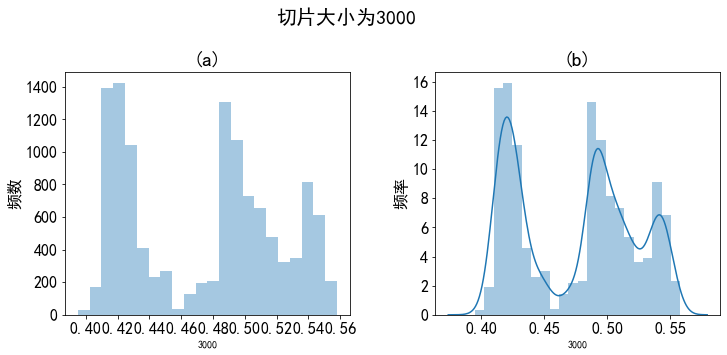

In [13]:
ts_len_list = ['100', '150', '200', '500', '1000', '3000']
# 画一大堆图
for i in ts_len_list:
    plt.figure(figsize=(16,9))
    plt.ylabel(u"Hurst 指数", fontsize=20)
    plt.xlabel(u"天数", fontsize=20)
    plt.xticks(fontsize=16)                    #
    plt.yticks(fontsize=16)                   
    plt.title(u"切片大小为"+i, fontsize=22)  
    plt.plot(hurst_df.loc[:,i])
    plt.show()
    plt.figure(figsize=(16, 9))
    
    plt.rcParams['figure.figsize'] = (13, 5)    #设定图片大小

    f = plt.figure()   #确定画布
    plt.suptitle(u"切片大小为"+i, fontsize=20, fontweight='bold')
    plt.subplots_adjust(left=0.2, wspace=0.8, top=0.8) 
    f.add_subplot(1,2,1)
    sns.distplot(hurst_df.loc[:,i], kde=False)                 #绘制频数直方图
    plt.ylabel(u"频数", fontsize=16)
    plt.xticks(fontsize=16)                    #设置x轴刻度值的字体大小
    plt.yticks(fontsize=16)                   #设置y轴刻度值的字体大小
    plt.title("(a)", fontsize=20)             #设置子图标题
    
    f.add_subplot(1,2,2)
    sns.distplot(hurst_df.loc[:,i])                           #绘制密度直方图
    plt.ylabel(u"频率", fontsize=16)
    plt.xticks(fontsize=16)                  #设置x轴刻度值的字体大小
    plt.yticks(fontsize=16)                  #设置y轴刻度值的字体大小
    plt.title("(b)", fontsize=20)            #设置子图标题

    plt.subplots_adjust(wspace=0.3)         #调整两幅子图的间距
    plt.show()

<AxesSubplot:>

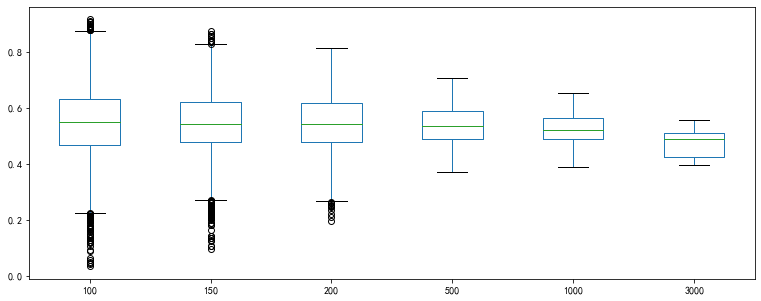

In [14]:
hurst_df.plot.box()

In [15]:
data_view=hurst_df.describe()
data_view.loc['range']=data_view.loc['max']-data_view.loc['min']
data_view.loc['variance']=hurst_df.var()
data_view.loc['standard deviation']=hurst_df.std()
data_view.loc['coefficient of variation']=data_view.loc['standard deviation']/data_view.loc['mean']
data_view

,100,150,200,500,1000,3000
count,12075.000000,12075.000000,12075.000000,12075.000000,12075.000000,12075.000000
mean,0.550989,0.548857,0.546889,0.537882,0.525020,0.474467
std,0.124465,0.105604,0.094724,0.067990,0.052214,0.046573
min,0.034073,0.096553,0.195386,0.371135,0.389166,0.395016
25%,0.469253,0.479710,0.477587,0.488454,0.490464,0.424637
50%,0.550861,0.544491,0.541562,0.534463,0.520751,0.487777
75%,0.633007,0.619728,0.619075,0.591045,0.565979,0.510482
max,0.916683,0.876481,0.812663,0.705510,0.651884,0.557850
range,0.882610,0.779928,0.617277,0.334375,0.262717,0.162834
variance,0.015492,0.011152,0.008973,0.004623,0.002726,0.002169


In [16]:
data1=np.array([all_mid_data,hurst_df.loc[:,'100'].to_numpy()])

data2=data1.T
print(data2.shape)
print(data2[::5])
#print(data2[0][1])

(12075, 2)
[[0.03143791 0.58929021]
 [0.15261841 0.64518576]
 [0.23024741 0.61560883]
 ...
 [1.0879207  0.60864739]
 [1.03975146 0.60220396]
 [1.04160901 0.69822587]]


In [17]:
result = []
sequence_length = 500
# 产生序列
for index in range(len(data2) - sequence_length):
    result.append(data2[index: index + sequence_length])
    
result = np.array(result)

row = round(0.8 * result.shape[0])

#creating training data
train = result[:int(row), :]

In [18]:
print(train.shape)
print(train[:5:])

(9260, 500, 2)
[[[0.03143791 0.58929021]
  [0.06067836 0.56717584]
  [0.08698315 0.60556432]
  ...
  [0.28564912 0.35089864]
  [0.29207687 0.4023155 ]
  [0.28881738 0.41020255]]

 [[0.06067836 0.56717584]
  [0.08698315 0.60556432]
  [0.11098009 0.61719339]
  ...
  [0.29207687 0.4023155 ]
  [0.28881738 0.41020255]
  [0.27300926 0.43465971]]

 [[0.08698315 0.60556432]
  [0.11098009 0.61719339]
  [0.132895   0.63454082]
  ...
  [0.28881738 0.41020255]
  [0.27300926 0.43465971]
  [0.27300926 0.41188896]]

 [[0.11098009 0.61719339]
  [0.132895   0.63454082]
  [0.15261841 0.64518576]
  ...
  [0.27300926 0.43465971]
  [0.27300926 0.41188896]
  [0.27617752 0.38972411]]

 [[0.132895   0.63454082]
  [0.15261841 0.64518576]
  [0.17132245 0.6301091 ]
  ...
  [0.27300926 0.41188896]
  [0.27617752 0.38972411]
  [0.27300926 0.40840226]]]


In [19]:
x_train = train[:,:-1]
y_train = train[:, -1][:,-2]

x_test = result[int(row):, :-1]
y_test = result[int(row):, -1][:,-2]

amount_of_features = 2

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features)) 

print("X_train", x_train.shape)
print("y_train", y_train.shape)
print("X_test", x_test.shape)
print("y_test", y_test.shape)

X_train (9260, 499, 2)
y_train (9260,)
X_test (2315, 499, 2)
y_test (2315,)


In [20]:
print(y_train[:5])
print(x_train[:5])

[0.28881738 0.27300926 0.27300926 0.27617752 0.27300926]
[[[0.03143791 0.58929021]
  [0.06067836 0.56717584]
  [0.08698315 0.60556432]
  ...
  [0.2571348  0.30678651]
  [0.28564912 0.35089864]
  [0.29207687 0.4023155 ]]

 [[0.06067836 0.56717584]
  [0.08698315 0.60556432]
  [0.11098009 0.61719339]
  ...
  [0.28564912 0.35089864]
  [0.29207687 0.4023155 ]
  [0.28881738 0.41020255]]

 [[0.08698315 0.60556432]
  [0.11098009 0.61719339]
  [0.132895   0.63454082]
  ...
  [0.29207687 0.4023155 ]
  [0.28881738 0.41020255]
  [0.27300926 0.43465971]]

 [[0.11098009 0.61719339]
  [0.132895   0.63454082]
  [0.15261841 0.64518576]
  ...
  [0.28881738 0.41020255]
  [0.27300926 0.43465971]
  [0.27300926 0.41188896]]

 [[0.132895   0.63454082]
  [0.15261841 0.64518576]
  [0.17132245 0.6301091 ]
  ...
  [0.27300926 0.43465971]
  [0.27300926 0.41188896]
  [0.27617752 0.38972411]]]


In [21]:
def build_model(input):
    model = Sequential()

    model.add(LSTM(200,input_shape=(input[1],input[0]),return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(200,return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(200,return_sequences=False))

    model.add(Dense(1, kernel_initializer="uniform"))
    model.compile(loss='mse',optimizer='adam',metrics=['mse', 'mae', 'mape', 'cosine'])
    return model

In [22]:
model = build_model([2,499,1])
print(model.summary())





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 499, 200)          162400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 499, 200)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 499, 200)          320800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 499, 200)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       


In [23]:
#from keras.utils import plot_model
#plot_model(model, to_file='model_test.png',show_shapes=True)

In [24]:
from timeit import default_timer as timer
start = timer()
history = model.fit(x_train,
                    y_train,
                    batch_size=50,
                    epochs=30,
                    validation_split=0.2,
                    verbose=2)
end = timer()
print(end - start)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 7408 samples, validate on 1852 samples
Epoch 1/30
 - 277s - loss: 0.0169 - mean_squared_error: 0.0169 - mean_absolute_error: 0.0694 - mean_absolute_percentage_error: 11800.1179 - cosine_proximity: -9.7597e-01 - val_loss: 4.3236e-04 - val_mean_squared_error: 4.3236e-04 - val_mean_absolute_error: 0.0152 - val_mean_absolute_percentage_error: 14904.1047 - val_cosine_proximity: -9.9946e-01
Epoch 2/30
 - 276s - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0286 - mean_absolute_percentage_error: 5121.6936 - cosine_proximity: -9.9595e-01 - val_loss: 3.7144e-04 - val_mean_squared_error: 3.7144e-04 - val_mean_absolute_error: 0.0145 - val_mean_absolute_percentage_error: 10815.5331 - val_cosine_proximity: -9.9946e-01
Epoch 3/30
 - 276s - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0270 - mean_absolute_percentage_error: 7702.7935 - cosine_proximity: -9.

Epoch 23/30
 - 303s - loss: 5.6594e-04 - mean_squared_error: 5.6594e-04 - mean_absolute_error: 0.0147 - mean_absolute_percentage_error: 731.3428 - cosine_proximity: -9.9460e-01 - val_loss: 1.0016e-04 - val_mean_squared_error: 1.0016e-04 - val_mean_absolute_error: 0.0072 - val_mean_absolute_percentage_error: 8630.0338 - val_cosine_proximity: -9.9946e-01
Epoch 24/30
 - 302s - loss: 5.5003e-04 - mean_squared_error: 5.5003e-04 - mean_absolute_error: 0.0143 - mean_absolute_percentage_error: 4872.8248 - cosine_proximity: -9.9406e-01 - val_loss: 1.3523e-04 - val_mean_squared_error: 1.3523e-04 - val_mean_absolute_error: 0.0091 - val_mean_absolute_percentage_error: 2877.3892 - val_cosine_proximity: -9.9946e-01
Epoch 25/30
 - 303s - loss: 5.8033e-04 - mean_squared_error: 5.8033e-04 - mean_absolute_error: 0.0146 - mean_absolute_percentage_error: 3350.6841 - cosine_proximity: -9.9433e-01 - val_loss: 1.7871e-04 - val_mean_squared_error: 1.7871e-04 - val_mean_absolute_error: 0.0104 - val_mean_absolu

In [25]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_mean_squared_error', 'val_mean_absolute_error', 'val_mean_absolute_percentage_error', 'val_cosine_proximity', 'loss', 'mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_proximity'])

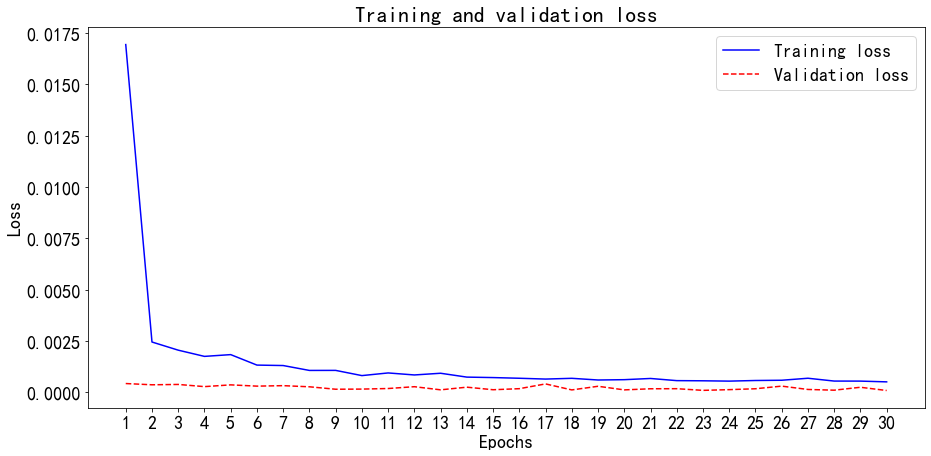

<Figure size 1296x648 with 0 Axes>

In [41]:
# Loss
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
loss_values50 = loss_values[0:150]
val_loss_values50 = val_loss_values[0:150]
epochs = range(1, len(loss_values50) + 1)
plt.plot(epochs, loss_values50, 'b',color = 'blue', label='Training loss')
plt.plot(epochs, val_loss_values50, 'b',color='red', label='Validation loss',linestyle='--')#验证损失
plt.rc('font', size = 18)
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(epochs)
fig = plt.gcf()
fig.set_size_inches(15,7)
#fig.savefig('img/validationlossconv1dlstm.png', dpi=300)
plt.figure(figsize = (18,9))
plt.show()

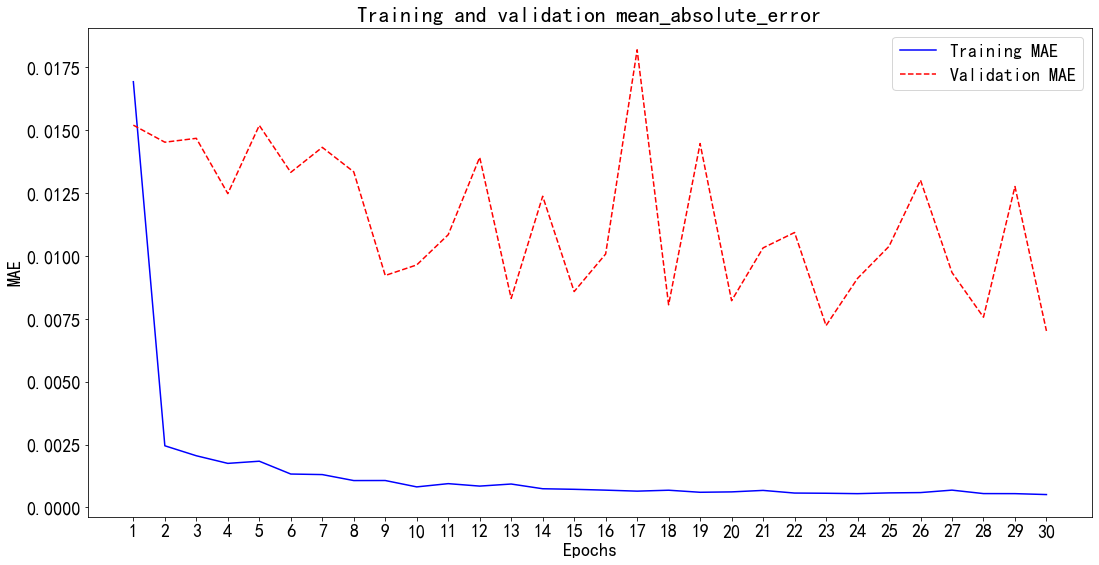

<Figure size 1296x648 with 0 Axes>

In [32]:
# MAE
mae = history_dict['mean_absolute_error']
vmae = history_dict['val_mean_absolute_error']
epochs = range(1, len(mse) + 1)
plt.plot(epochs, mae, 'b',color = 'blue', label='Training MAE')
plt.plot(epochs, vmae, 'b',color='red', label='Validation MAE',linestyle='--')
plt.title('Training and validation mean_absolute_error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.xticks(epochs)
fig = plt.gcf()
fig.set_size_inches(18,9)
#fig.savefig('img/validationlossconv1dlstm.png', dpi=300)
plt.figure(figsize = (18,9))
plt.show()

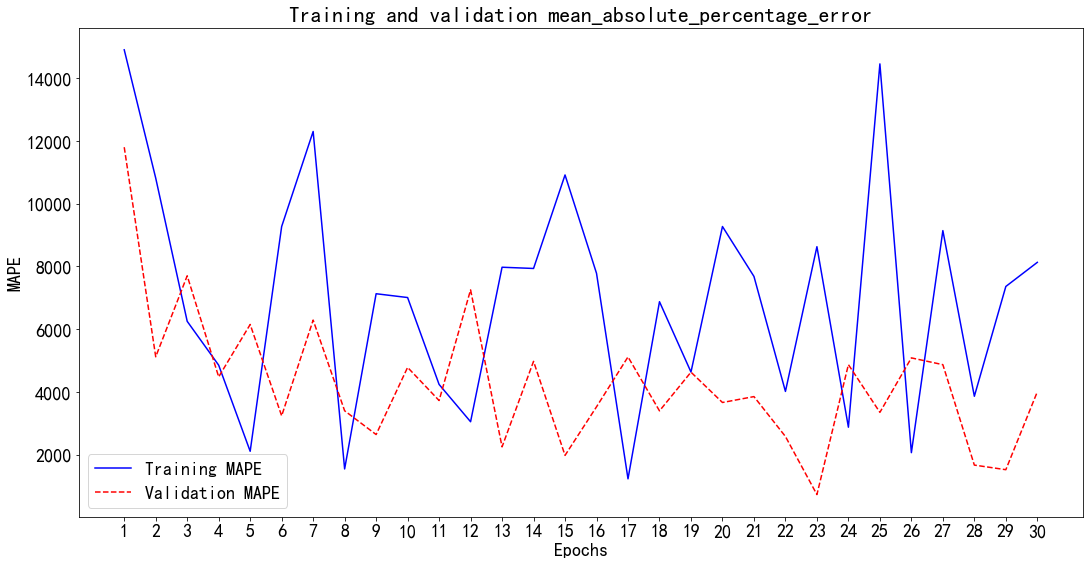

<Figure size 1296x648 with 0 Axes>

In [42]:
# MAPE
mape = history_dict['val_mean_absolute_percentage_error']
vmape = history_dict['mean_absolute_percentage_error']
epochs = range(1, len(mse) + 1)
plt.plot(epochs, mape, 'b',color = 'blue', label='Training MAPE')
plt.plot(epochs, vmape, 'b',color='red', label='Validation MAPE',linestyle='--')
plt.title('Training and validation mean_absolute_percentage_error')
plt.xlabel('Epochs')
plt.ylabel('MAPE')
plt.legend()
plt.xticks(epochs)
fig = plt.gcf()
fig.set_size_inches(18,9)
#fig.savefig('img/validationlossconv1dlstm.png', dpi=300)
plt.figure(figsize = (18,9))
plt.show()

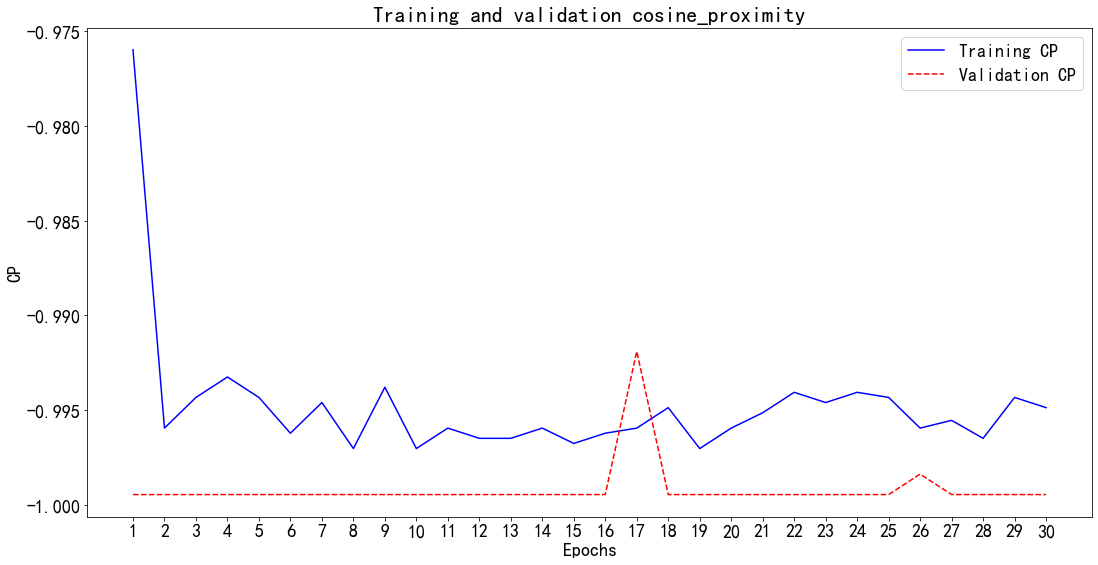

<Figure size 1296x648 with 0 Axes>

In [38]:
cp = history_dict['cosine_proximity']
vcp = history_dict['val_cosine_proximity']
epochs = range(1, len(mse) + 1)
plt.plot(epochs, cp, 'b',color = 'blue', label='Training CP')
plt.plot(epochs, vcp, 'b',color='red', label='Validation CP',linestyle='--')
plt.title('Training and validation cosine_proximity')
plt.xlabel('Epochs')
plt.ylabel('CP')
plt.legend()
plt.xticks(epochs)
fig = plt.gcf()
fig.set_size_inches(18,9)
#fig.savefig('img/validationlossconv1dlstm.png', dpi=300)
plt.figure(figsize = (18,9))
plt.show()

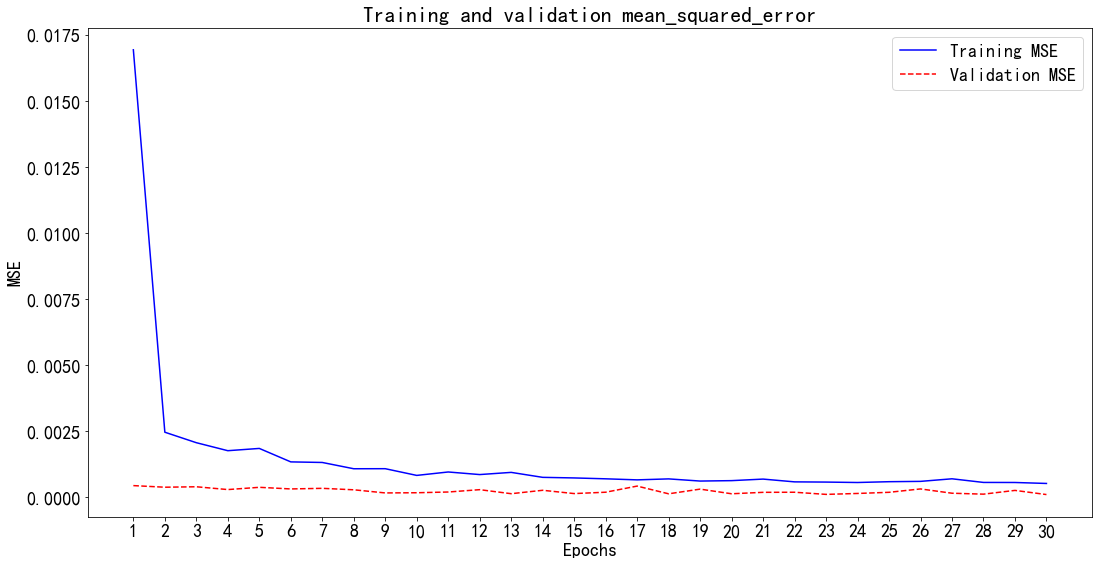

<Figure size 1296x648 with 0 Axes>

In [27]:
mse = history_dict['mean_squared_error']
vmae = history_dict['val_mean_squared_error']
epochs = range(1, len(mse) + 1)
plt.plot(epochs, mse, 'b',color = 'blue', label='Training MSE')
plt.plot(epochs, vmae, 'b',color='red', label='Validation MSE',linestyle='--')
plt.title('Training and validation mean_squared_error')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.xticks(epochs)
fig = plt.gcf()
fig.set_size_inches(18,9)
#fig.savefig('img/validationlossconv1dlstm.png', dpi=300)
plt.figure(figsize = (18,9))
plt.show()

In [28]:
trainScore = model.evaluate(x_train, 
                            y_train, 
                            verbose=2)
testScore = model.evaluate(x_test, y_test, verbose=0)

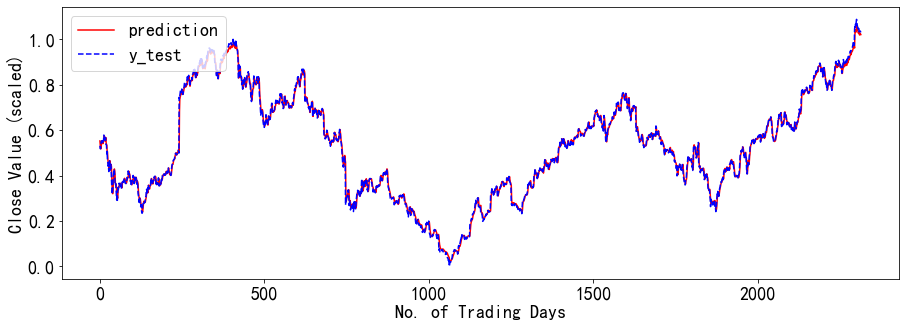

In [29]:
p = model.predict(x_test)
plt.plot(p,color='red', label='prediction')
plt.plot(y_test,color='blue', label='y_test',linestyle='--')
plt.xlabel('No. of Trading Days')
plt.ylabel('Close Value (scaled)')
plt.legend(loc='upper left')
fig = plt.gcf()
fig.set_size_inches(15, 5)
#fig.savefig('img/25/mrftestconv1dlstm.png', dpi=300)
plt.show()